In [2]:
import numpy as np
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import quad, cumtrapz
from scipy.misc import derivative
import matplotlib.pyplot as plt

h = 0.6774
Omega_m = 0.32
Omega_b = 0.048
Omega_Lambda = 0.68
H0 = 67.72  # km/s/Mpc
rho_c = 2.7752e11 * h**2  # M_sun/Mpc^3
rho_m = rho_c * Omega_m
f_s = 0.1

In [3]:
data = np.loadtxt('dn_dM.txt', skiprows=1)
n = 1001  
gridx = data[::n, 0] 
gridy = np.log(data[0:n, 1]) 
values = data[:, 2].reshape(len(gridy), len(gridx), order='F')

interpolator = RegularGridInterpolator(
    (gridx, gridy), values.T, method='linear', bounds_error=False, fill_value=None
)

def dndM(m, z):
    logm = np.log(m)
    point = np.array([[z, logm]])
    return interpolator(point)[0]

# test
z_test=4.13
m_test=1.2e5
dndM(m_test, z_test)

0.049523947983276584

In [4]:
def M_min(z):
    return 2.8e9 * (1+z)**(-1.5)

def integrand(logM, z):
    M = 10**logM
    return M * dndM(M, z) * M * np.log(10)  # dM = M ln(10) d(logM)

def f_coll(z):
    logM_min = np.log10(M_min(z))
    logM_arr = np.linspace(logM_min, 18, 500)  # 足够多点数
    M_arr = 10**logM_arr
    dndM_arr = np.array([dndM(M, z) for M in M_arr])
    
    integrand_arr = M_arr**2 * np.log(10) * dndM_arr
    integral = np.trapz(integrand_arr, logM_arr)
    
    return integral / rho_m

f_coll(z_test)

0.18671691487998343

In [5]:
z_values = np.linspace(0, 30, 100)
f_values = np.array([f_coll(z) for z in z_values])

dfdz = np.gradient(f_values, z_values)

interp_dfdz = interp1d(z_values, dfdz, kind='cubic', fill_value='extrapolate')

In [6]:
def H(z):
    return H0 * np.sqrt(Omega_m*(1+z)**3 + Omega_Lambda)

def dzdt(z):
    return -(1+z) * H(z) * 1e3 / 3.086e22  # 转换单位：km/s/Mpc -> s^-1

def SFRD(z):
    return f_s * (Omega_b/Omega_m) * rho_m * interp_dfdz(z) * dzdt(z)

SFRD(z_test)

2.483558430882851e-09

In [7]:
sed_data = np.loadtxt('SED.txt')
nu_sed = sed_data[:, 0]  # Hz
s_nu = sed_data[:, 1]    # erg/s/Hz/(M_sun/yr)
interp_sed = interp1d(nu_sed, s_nu, kind='cubic', bounds_error=False, fill_value=0)

In [8]:
c = 3e8  # m/s
Hz_to_ev = 4.1357e-15  # 1 Hz -> eV

def compute_J(nu_obs, apply_absorption=True):
    z_min, z_max = 5, 30
    z_arr = np.linspace(z_min, z_max, 300)
    dz = np.gradient(z_arr)
    
    J = np.zeros_like(nu_obs)
    
    for i, nu in enumerate(nu_obs):
        nu_emit_arr = nu * (1 + z_arr)
        
        # 吸收
        if apply_absorption:
            mask = np.ones_like(z_arr, dtype=bool)
            mask[(z_arr > 6) & (nu_emit_arr > 2.47e15)] = False
        else:
            mask = np.ones_like(z_arr, dtype=bool)

        s_arr = interp_sed(nu_emit_arr)
        sfrd_arr = np.array([SFRD(z) for z in z_arr])
        H_z_arr = H(z_arr) * 1e3 / 3.086e22  # km/s/Mpc -> s^-1

        e_arr = s_arr * sfrd_arr
        integrand_arr = e_arr * c / H_z_arr * (1 + z_arr) * mask
        
        Mpc2_to_cm2 = (3.086e24)**2  # 转换 Mpc² -> cm²
        J[i] = np.trapz(integrand_arr, z_arr) / (4 * np.pi * Mpc2_to_cm2)

    return J

wavelengths = np.linspace(0.1, 10, 100)  # μm
nu_obs = c / (wavelengths*1e-6)  # Hz

J_no_abs = compute_J(nu_obs, apply_absorption=False)
J_with_abs = compute_J(nu_obs, apply_absorption=True)

for λ in [0.1, 1, 5, 10]:
    ν = c / (λ * 1e-6)
    j_val = compute_J(np.array([ν]), apply_absorption=False)[0]
    print(f"λ = {λ:.2f} μm J = {j_val:.3e}")

λ = 0.10 μm J = 9.635e-09
λ = 1.00 μm J = 7.460e-05
λ = 5.00 μm J = 4.411e-05
λ = 10.00 μm J = 2.646e-05


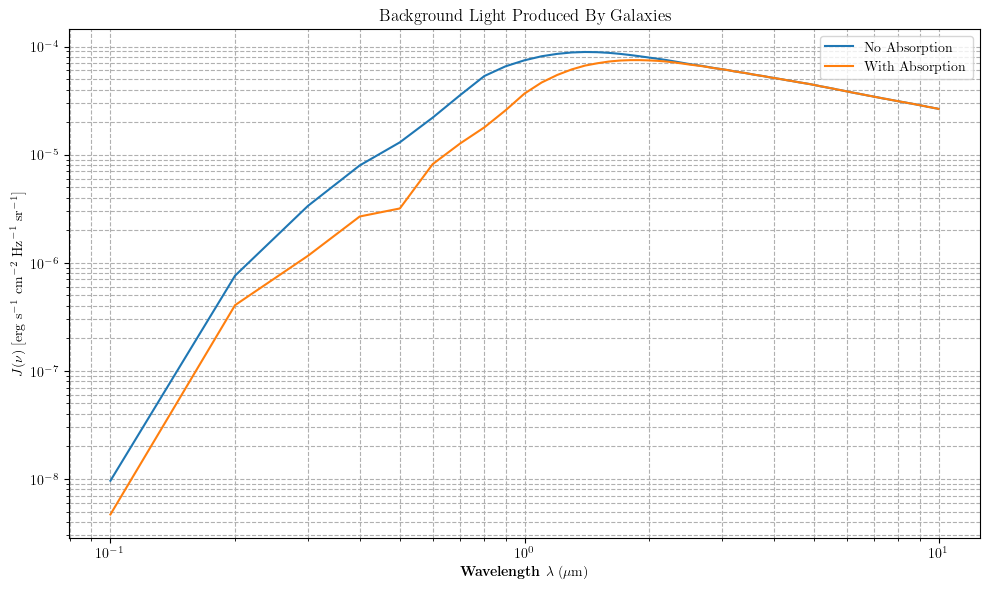

In [9]:
plt.figure(figsize=(10,6))
plt.plot(wavelengths, J_no_abs, label='No Absorption')
plt.plot(wavelengths, J_with_abs, label='With Absorption')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'\textbf{Wavelength} $\lambda\ (\mu\mathrm{m})$')
plt.ylabel(r'$J(\nu)\; [\mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{Hz}^{-1}\ \mathrm{sr}^{-1}]$')
plt.title('Background Light Produced By Galaxies')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.savefig('Background Light Produced By Galaxies',dpi = 300,bbox_inches='tight')
plt.show()